In [90]:
import torch
from datasets import load_dataset
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict

In [14]:
dataset = load_dataset("Isamu136/big-animal-dataset")
train_dataset = dataset["train"]
print(train_dataset)

Generating train split:   0%|          | 0/62149 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'caption'],
    num_rows: 62149
})


In [16]:
train_size = 100
train_dataset = train_dataset.shuffle(seed=42).select(range(train_size))

In [60]:
print(train_size)
caption_to_label = {}
label_to_caption = {}

caption_set = list(set(train_dataset["caption"]))
for i in range(0, len(caption_set)):
    caption_to_label[caption_set[i]] = i
    label_to_caption[i] = caption_set[i]
    
    
    
num_classes = max(label_to_caption.keys()) + 1
print(num_classes)
print(label_to_caption)

100
50
{0: 'Cardigan', 1: 'chicken', 2: 'Blenheim_spaniel', 3: 'miniature_schnauzer', 4: 'butterfly', 5: 'leonberger', 6: 'Pembroke', 7: 'African_hunting_dog', 8: 'Abyssinian', 9: 'EntleBucher', 10: 'Pomeranian', 11: 'Norfolk_terrier', 12: 'wheaten terrier', 13: 'Newfoundland', 14: 'otterhound', 15: 'cocker_spaniel', 16: 'samoyed', 17: 'Pekinese', 18: 'groenendael', 19: 'dog', 20: 'cat', 21: 'miniature pinscher', 22: 'Birman', 23: 'keeshond', 24: 'Boston_bull', 25: 'beagle', 26: 'american pit bull terrier', 27: 'spider', 28: 'sheep', 29: 'boxer', 30: 'curly-coated_retriever', 31: 'Egyptian Mau', 32: 'Bouvier_des_Flandres', 33: 'elephant', 34: 'Samoyed', 35: 'basenji', 36: 'schipperke', 37: 'Maine Coon', 38: 'squirrel', 39: 'cow', 40: 'Norwich_terrier', 41: 'Bengal', 42: 'collie', 43: 'horse', 44: 'Irish_wolfhound', 45: 'dhole', 46: 'bluetick', 47: 'West_Highland_white_terrier', 48: 'Maltese_dog', 49: 'Shetland_sheepdog'}


In [77]:
image_size = 224
image_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),    # Resize to the target size
    transforms.ToTensor(),          # Convert to a PyTorch tensor
])

class MyCustomDataset(torch.utils.data.Dataset):
    def __init__(self, your_data_here):
        self.data = your_data_here

    def __len__(self):
        return len(self.data['image'])

    def __getitem__(self, idx):
        return {
            'image': image_transform(self.data['image'][idx]),
            'caption': self.data['caption'][idx],
            'label': caption_to_label[self.data['caption'][idx]],
        }
    
# Finally create the dataloader
my_train_dataset = MyCustomDataset(train_dataset)
train_dataloader = torch.utils.data.DataLoader(my_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = torchvision.models.vision_transformer.VisionTransformer(        
#         image_size = image_size,
#         patch_size = 8,
#         num_layers = 10,
#         num_heads = 4,
#         hidden_dim = 64,
#         mlp_dim = 128,
#         dropout = 0.2,
#         attention_dropout = 0.2,
#         num_classes = num_classes).to(device)
model = torchvision.models.vit_b_16().to(device)
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [80]:
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


images = None
labels = None

iters = 100
loss_list = []
for iter in tqdm(range(0, iters)):
    iter_loss = 0
    for i, data_batch in enumerate(train_dataloader):
        images = data_batch["image"].to(device)
        print(images.shape)
        labels = data_batch["label"].to(device)
        
        pred = model(images)
        loss = criterion(pred.float(), labels.long())
        iter_loss += loss.data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_list.append(iter_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3,

KeyboardInterrupt: 

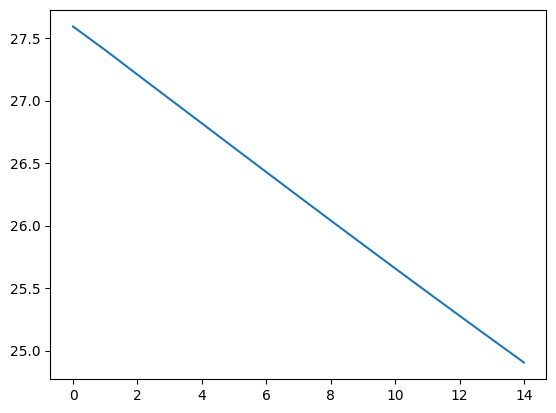

In [81]:
plt.plot(loss_list)

In [117]:
class MLP(nn.Module):
    def __init__(self, hidden_dim=768, mlp_dim=3072):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(hidden_dim, mlp_dim)
        self.activation = nn.GELU()
        self.dropout1 = nn.Dropout(0.2)
        self.linear2 = nn.Linear(mlp_dim, hidden_dim)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.dropout2(x)
        return x
    

class MultiheadAttentionBlock(nn.Module):
    def __init__(self, embed_size, num_heads, p=0.2):
        super(MultiheadAttentionBlock, self).__init__()

        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)
        self.dropout = nn.Dropout(p)
        self.linear = nn.Linear(embed_size, embed_size)

    def forward(self, query, key, value, mask=None):
        N = query.shape[0]

        query = self.query(query)
        key = self.key(key)
        value = self.value(value)

        query = query.view(N, -1, self.num_heads, self.head_dim)
        key = key.view(N, -1, self.num_heads, self.head_dim)
        value = value.view(N, -1, self.num_heads, self.head_dim)

        query = query.permute(0, 2, 1, 3)
        key = key.permute(0, 2, 1, 3)
        value = value.permute(0, 2, 1, 3)

        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / torch.sqrt(
            torch.tensor(self.head_dim, dtype=torch.float32)
        )

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-1e20"))

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        output = torch.matmul(attention_weights, value)
        output = output.permute(0, 2, 1, 3).contiguous()
        output = output.view(N, -1, self.embed_size)

        output = self.linear(output)
        return output, attention_weights
    
    
class EncoderBlock(nn.Module):
    def __init__(self, num_classes, image_size=224, patch_size=16, num_layers=12, num_heads=12, hidden_dim=768, mlp_dim=3072):
        super(EncoderBlock, self).__init__()
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.attention_layer = MultiheadAttentionBlock(hidden_dim, num_heads)
#         self.attention_layer = nn.MultiheadAttention(hidden_dim, num_heads, dropout=0.2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.mlp = MLP(hidden_dim, mlp_dim)
        
    def forward(self, input):
        x = self.ln1(input)
        x, _ = self.attention_layer(x, x, x)
        x = self.dropout(x)
        
        x = x + input
        
        y = self.ln2(x)
        y = self.mlp(y)
        return y + x

        
class MyVisionTransformer(nn.Module):
    def __init__(self, num_classes, image_size=224, patch_size=16, num_layers=12, num_heads=12, hidden_dim=768, mlp_dim=3072):
        super(MyVisionTransformer, self).__init__()
        
        self.conv_layer = nn.Conv2d(in_channels=3, out_channels=hidden_dim, kernel_size=patch_size, stride=patch_size)
        
        seq_len = (image_size // patch_size) ** 2 + 1  # we have a class token
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_len, hidden_dim).normal_(std=0.02))
        self.encoder_dropout = nn.Dropout(0.2)
        encoders = OrderedDict()
        for i in range(num_layers):
            encoders[f"encoder_layer_{i}"] = EncoderBlock(num_classes, image_size, patch_size, num_layers, num_heads, hidden_dim, mlp_dim)
        self.encoders = nn.Sequential(encoders)
        self.encoder_ln = nn.LayerNorm(hidden_dim)
        
        self.class_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))
        
        self.proj_layer = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, image_batch):
        conv_result = self.conv_layer(image_batch)
        embedding = conv_result.reshape(conv_result.shape[0], conv_result.shape[1], -1).permute(0, 2, 1)
        batch_class_token = self.class_token.expand(image_batch.shape[0], -1, -1)

        embedding = torch.cat([batch_class_token, embedding], dim=1)
        embedding = embedding + self.pos_embedding
        
        encoder_output = self.encoder_ln(self.encoders(self.encoder_dropout(embedding)))
        batch_class_token_output = encoder_output[:, 0, :]
        
        pred_prob = self.proj_layer(batch_class_token_output)
        
        return pred_prob

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyVisionTransformer(num_classes).to(device)
print(model)

MyVisionTransformer(
  (conv_layer): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder_dropout): Dropout(p=0.2, inplace=False)
  (encoders): Sequential(
    (encoder_layer_0): EncoderBlock(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attention_layer): MultiheadAttentionBlock(
        (query): Linear(in_features=768, out_features=768, bias=True)
        (key): Linear(in_features=768, out_features=768, bias=True)
        (value): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear): Linear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (activation): GELU(approximate='none')
        (dropout1): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=30

In [119]:
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


images = None
labels = None

iters = 100
loss_list = []
for iter in tqdm(range(0, iters)):
    iter_loss = 0
    for i, data_batch in enumerate(train_dataloader):
        images = data_batch["image"].to(device)
        labels = data_batch["label"].to(device)
        
        pred = model(images)
        loss = criterion(pred.float(), labels.long())
        iter_loss += loss.data
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss_list.append(iter_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 768, 14, 14])
torch.Size([32, 196, 768])
torch.Size([32, 1, 768])
torch.Size([32, 197, 768])
torch.Size([1, 197, 768])


KeyboardInterrupt: 